<a href="https://colab.research.google.com/github/choijiwoong/samples_for_colab/blob/main/%EB%AC%B88.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

  [1. 배경지식]

MNIST 데이터는 http://yann.lecun.com/exdb/mnist에서 제공하는 데이터로, 숫자 0부터 9까지의 손글씨 이미지(28x28)로 구성된 데이터셋이다.
총 60,000개의 훈련 데이터와 레이블, 총 10,000개의 테스트 데이터와 레이블로 구성되어 있다.
 MNIST 데이터를 사용한 MNIST데이터 문제는 이러한 손글씨 숫자 이미지가 입력으로 들어왔을때, 해당 숫자가 몇인지를 맞추는 문제이다. MNIST데이터의 경우 이미지의 크기도 28x28로 상대적으로 작고, 기본적인 문제인만큼 숫자가 웬만큼 올바르게 중앙에 담겨있어 고려할 변수가 단순해지기에 간단한 선형 모델로도 문제 해결이 가능하다.
 그렇기에 28x28이미지를 784의 선형 sequence로 바꾸어 모델의 입력으로 넣는 방법을 택했다.

[2. 모듈 임포트]

In [1]:
import torch

학습에 사용할 모듈은 PyTorch이다.
 

In [2]:
import torchvision.datasets as dsets

torch에서는 torchvision, torchtext등 유명한 데이터셋이나 모델들을 제공해주는 기능을 자체적으로 제공해준다. 고로 MNIST데이터셋을 가져오는데에도 torchvision.datasets.MNIST를 사용할 것이다.

In [3]:
import torchvision.transforms as transforms

torchvision.transforms는 torchvision.datasets.MNIST를 통해 데이터셋을 다운받을때, 해당 데이터의 타입을 변경하기 위해 사용한다. 실제 다운받는 코드를 보면 torchvision.transforms.ToTensor을 사용하여 MNIST데이터셋의 데이터형식을 torch.Tensor라는 타입으로 변환한다.
Tensor는 Torch에서 자체적으로 사용하는 데이터유형인데 일반적인 데이터타입이 아닌 머신러닝을 위해 최적화된 데이터 타입이다. 예를 들어 역전파를 위해 .grad속성이 default None으로 설정되어 있다.

In [4]:
from torch.utils.data import DataLoader

실제로 학습을 진행할때, 수많은 데이터를 사용하여 학습을 진행하게 되는데 데이터를 하나하나 학습할때마다 오차를 계산하고 이를 모델에 반영하다보면 정말 오랜 시간과 자원이 소모되게된다. 고로 대게 많은 양의 데이터를 학습시킬때는 데이터를 여러개를 하나로 묶어 나온 오차를 한꺼번에 모델에 반영시키는 방법을 사용하는데, 이러한 묶여진 데이터의 단위를 batch라고 한다.
 batch작업을 보다 편리하게 하기 위해서 torch에서는 torch.utils.data를 제공하는데 데이터만 전달해주면 인자로 전달된 batch_size만큼 slicing하여 반환해준다.

In [5]:
import torch.nn as nn
import matplotlib.pyplot as plt
import random

torch.nn에서는 모델을 설계할때 사용할 수 있는 (여러 레이어를 묶을 수 있는)컨테이너, (오차계산에 사용하는)손실함수, 레이어 등 여러 종류의 설계블록을 제공해준다. 아래에 MNIST학습에 사용할 때 역시 torch.nn.Linear 레이어를 사용한다.

[3. 데이터 학습을 위한 준비]

In [6]:
USE_CUDA=torch.cuda.is_available()
device=torch.device("cuda" if USE_CUDA else "cpu")
print("학습을 진행할 기기: ", device)

학습을 진행할 기기:  cuda


CUDA는 엔비디아에서 제공해주는 GPU에서 수행하는 병렬 연산들을 일반적인 프로그래밍언어를 통해 연산가능하게 해주는 기능이다. 우선 GPU는 Graphics Processing Unit으로 일반적으로 연산에 사용된다고 알고있는 CPU(Core Processing Unit)과는 다른 작업을 전담한다. CPU의 하나의 코어는 강력한 연산수준을 제공하지만, 한번에 하나의 일만을 할 수 있다. 다만 정말 짧은 시간동안 수많은 프로세스들을 나누어 처리하며 한번에 처리되는것처럼 보이게하는 context switching을 사용할 뿐이다. 하지만 모니터에 항시 변하는 pixel값들을 연산하는 작업은 한번에 하나씩 처리하는 CPU가 처리하기엔 너무 쉬운 연산이지만 양이 많아 비효율적이다. 고로 쉬운 연산을 한꺼번에 처리하는 병렬연산을 전담하는 장치를 새로이 넣었는데 그것이 GPU이다.
 앞서 말했던 것처럼 GPU를 사용할 수 있게하는 CUDA를 사용하는 이유는 모델에 사용하는 데이터들이 일반적으로 행렬구조를 띄는 병렬데이터이고, 모델을 발전시키기 위해 오차를 계산하는 과정에서 사용하는 미분 과정이 연쇄적으로 이루어지는 굉장히 간단한 연산이기에 이러한 연산을 GPU에 위임하여 병렬연산을 효과적으로 하여 빠른 모델학습을 가능하게하기 위함이다.
  위의 코드는 NVIDIA GPU에서 제공하는 CUDA가 사용가능하면 연산에 사용할 장치를 GPU로, 그렇지 않으면 CPU로 진행하게끔 장치를 지정하는 부분이다.

In [7]:
#Hyperparameters
training_epochs=15
batch_size=100

전반적인 모델의 중요 인자들을 HyperParameter라고하여 정리해두는데, batch_size는 위에서 설명을 해두었고 training_epochs는 하나의 데이터셋을 한번만 학습시키면 모델이 온전히 학습하지 못할 수도 있기에 같은 데이터를 여러번 학습시키는데 그 횟수이다.

In [8]:
mnist_train=dsets.MNIST(root='MNIST_data/',
                        train=True,
                        transform=transforms.ToTensor(),
                        download=True)

mnist_test=dsets.MNIST(root='MNIST_data/',
                       train=False,
                       transform=transforms.ToTensor(),
                       download=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to MNIST_data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to MNIST_data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST_data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST_data/MNIST/raw



torchvision.datasets.MNIST를 활용하여 모델학습에 사용할 훈련 데이터와 테스트 데이터를 다운받는 과정이다. transform은 위 모델 임포트에서 한번 설명했듯이 다운받은 데이터셋의 데이터형식을 학습가능한 torch.Tensor타입으로 변환시키는 과정이다.
 일반적으로 모델을 학습시키는데에 훈련데이터만이 필요한 것이 아니다. 크게 훈련데이터, 검증데이터, 테스트데이터로 분류된다. 훈련데이터는 말그대로 훈련에 사용될 데이터이고 검증데이터는 학습과정에서 바뀌는 레이어의 일반적인 파라미터가아닌 모델의 중요 인자인 하이퍼파라미터를 조정하기 위한 데이터이며, 테스트데이터는 모델의 성능을 확인하기 위한 데이터이다. 현재 MNIST데이터를 학습하는데에는 60,000개의 훈련데이터와 10,000개의 테스트데이터만을 사용한다.

In [9]:
data_loader=DataLoader(dataset=mnist_train, batch_size=batch_size, shuffle=True, drop_last=True)

MNIST훈련 데이터셋을 하이퍼파라미터인 batch_size만큼씩 반환할 수 있는 iterator형식으로 반환해준다. drop_last는 batch_size만큼 잘랐을때 가장 마지막에 남게되는 데이터를 사용할것인지 말것인지를 말하는 것인데, 마지막 남은 데이터의 양이 batch_size보다 적은 경우 그 데이터에 대해 오버피팅될 (데이터를 균일하게보지않고 마지막 데이터가 조금 더 중요한 데이터다 라는 판단)가능성을 막아준다.

In [10]:
linear=nn.Linear(784, 10).to(device)

784개의 입력데이터(28x28 손글씨 사진)를 받아 10개(0~9)의 데이터를 출력하게하는 선형 레이어를 정의했다.

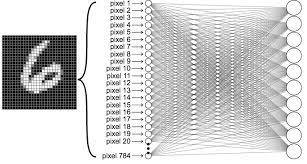

In [11]:
criterion=nn.CrossEntropyLoss().to(device)

크로스 엔트로피 손실함수를 이해하기 위해서는 우선 소프트맥스 함수에 대해 이해해야하는데, 선형 레이어의 경우 입력된 데이터를 X라고 할때 WX+b의 출력을 만들어낸다. W과 b는 각각 weight와 bias로 우리가 학습시킬 파라미터에 해당한다.
우리는 모델을 통해 MNIST 손글씨 사진이 0-9의 숫자중에 가장 가능성이 높은 숫자를 판단해야하기에 입력으로 들어온 손글씨 데이터가 0-9일 확률을 각각 구한 뒤 가장 높은 확률의 숫자로 판단해야한다. 즉 요점은 0-9일 확률을 구해야한다는 건데 Linear을 통과한 데이터는 WX+b의 값을 띄기에 이를 확률데이터로 계산할 수 있도록 활성화 함수라는 것을 거친다. 대표적인 활성화함수인 sigmoid의 모양은 아래와 같다.

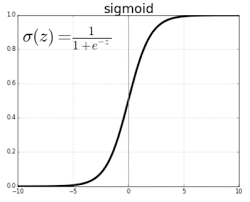

이 sigmoid함수는 WX+b를 통해 나온 값들을 (0.0, 1.0)범위로 정규화해준다. 하지만 이 값 자체는 확률값이 아니다. 단순히 정규화된 값이기에 이를 실제 확률로서 계산하기위해서는 Linear을 통해 나온 0-9까지의 값들을 모두 더한뒤 각각의 값이 차지하는 값의 비율을 구해 실제 확률을 구한다. 이러한 작업을 하는 함수가 소프트맥스 함수이다. 아래의 함수는 시그모이드함수를 일반화하여 e^x꼴로 나타낸 소프트맥스함수이다.

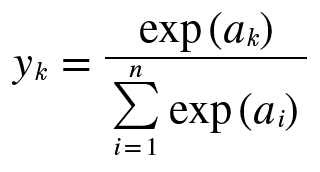

이렇게 도출된 확률에 log를 씌워 실제 label값과 곱한뒤 -를 위하면 크로스엔트로피 손실함수가 된다. 크로스엔트로피에 관한 자세한 설명은 실제 크로스엔트로피 수식을 놓고 설명하도록 하겠다. 아래의 그림이 크로스엔트로피 함수이며 k는 클래스의 개수, y는 실제 레이블, p는 (소프트맥스를 통하여 얻은)우리가 구한 확률이다.

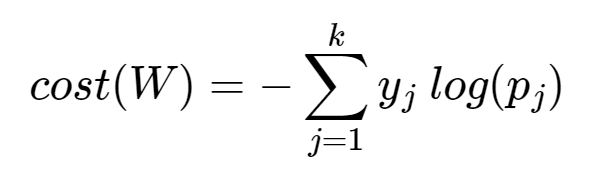

우선 원-핫 벡터에 관한 개념부터 설명하겠다. 원-핫 벡터란 0과 1로만 이루어진 확률데이터로 일반적인 확률데이터 [0.1, 0.3, 0.6]을 원-핫 벡터로 만들면 가장 높은 확률을 가진것만 살려서 [0, 0, 1]가 된다. 고로 label데이터인 y역시 0부터 9까지의 값중 실제 답인 것을 표시하기 위해 원-핫 벡터를 사용하며 7이 답인 경우 [0, 0, 0, 0, 0, 0, 1, 0, 0, 0]가 레이블 데이터가 되게 된다. 우리가 소프트맥스를 통해 얻은 확률 데이터 p는 [0.0, 1.0]의 범위를 띄기 때문에 log없이 그냥 y과 곱해버리면 단순히 레이블에 대해 모델이 예측한 확률값에 불과하다. 문제는 우리는 오차율을 알기위해 손실함수를 사용하는 것인데 [0.0, 1.0]범위의 값은 손실값으로 사용하기에 너무 작은 값이라는 단점이 있다. 고로 로그함수가 (0.0, 1)부분에서 가파른 모양이라는 것을 이용해 확률에 log를 취한 값을 레이블과 곱해 손실값을 극대화시키려는 것이다. 로그함수 특성항 [0.0, 1.0]은 음수이기에 양숫값을 만들어주고자 -를 붙여 크로스엔트로피 함수가 탄생한다.

In [12]:
optimizer=torch.optim.SGD(linear.parameters(), lr=0.1)

모델이 학습하게하는 방향은 오차(손실)값이 최소화되는 방향을 따르기에 손실함수의 값이 최소가 되는 지점 즉, 극솟값을 찾는것이 모델학습의 목표이다. 고로 손실함수를 미분해서 기울기가 낮은 방향으로 향하게하는데 이 때 사용하는 대표적인 방법이 Stochastic Gradient Descent(확률적 경사 하강법) SGD이다. 아래의 그림이 SGD에 대한 함수이다.

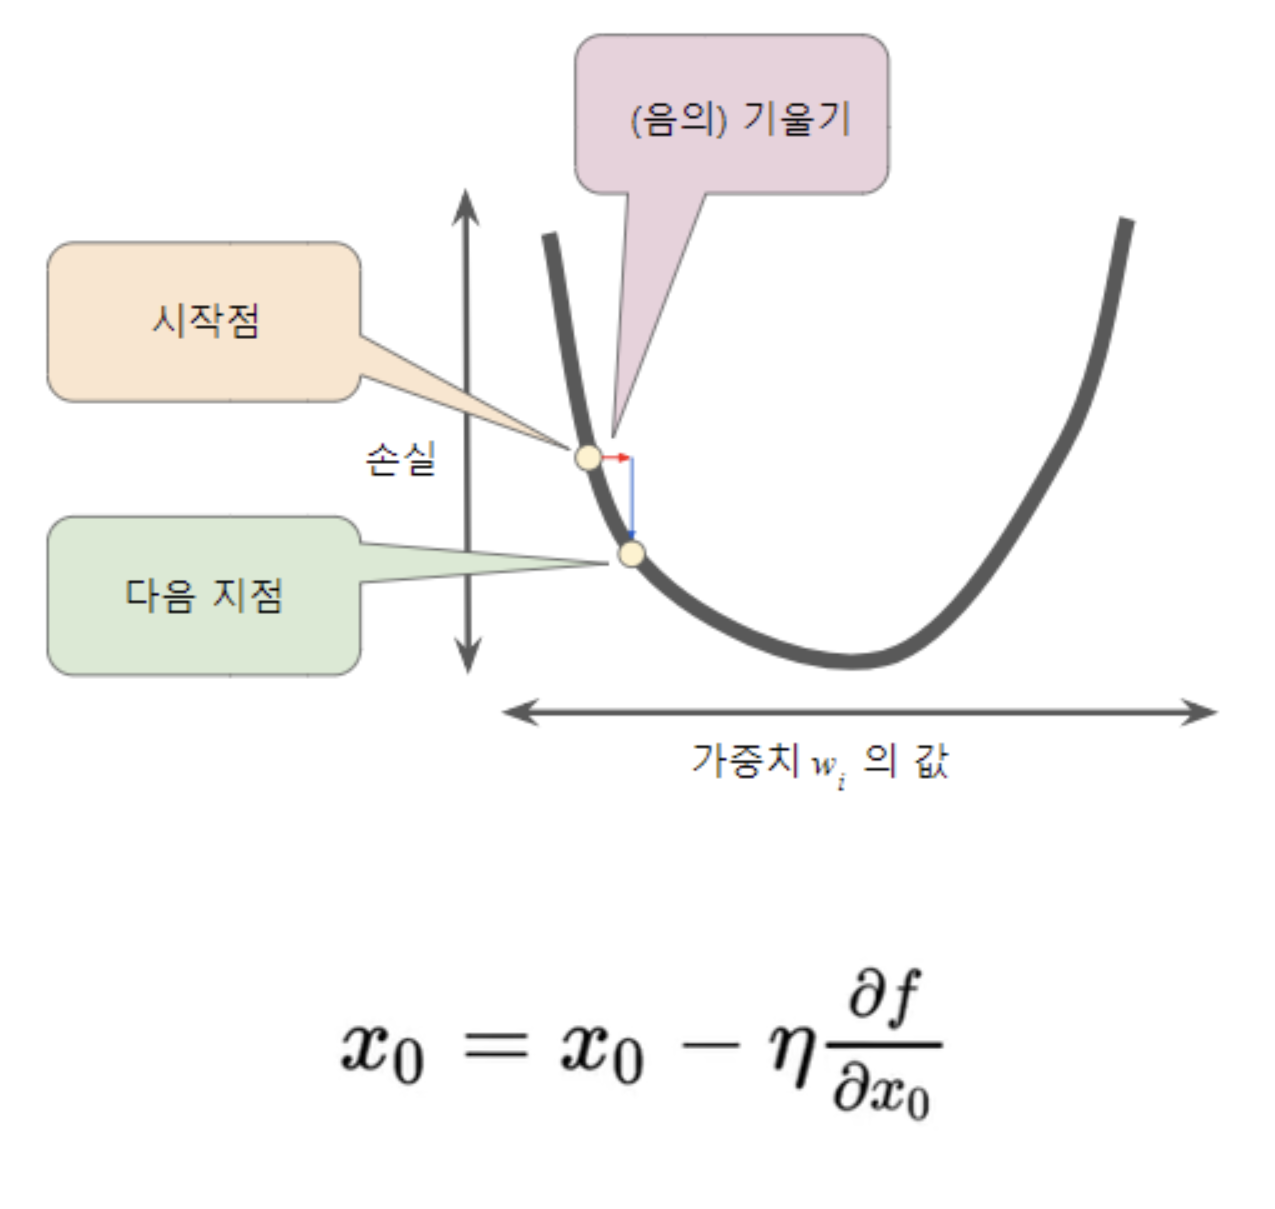

어려울것 없이 위 그림은 x=x-learning_rate * 손실함수미분값 인데
미분값이 음수라면 극솟값에 가까워지기위해 x값을 오른쪽 방향으로 옮겨야함을 의미하고, 반대로 미분값이 양수라면 극솟값에 가까워지기위해 x값을 왼쪽 방향으로 옮겨야함을 의미한다. 고로 -를 붙여 전자의 경우엔 x값을 오른쪽으로, 후자의 경우엔 x값이 왼쪽으로 옮겨지게 한다. 이때 미분값에 곱해지는 learning_rate는 얼마나 옮길지의 폭을 정하는 것이다.

[4. 데이터 학습시키기]

In [13]:
for epoch in range(training_epochs):
  avg_cost=0#하나의 에포크동안의 평균 손실값
  total_batch=len(data_loader)#batch단위로 data_loader가 로드한다. 

  for X,Y in data_loader:
    X=X.view(-1, 28*28).to(device)#(28x28)손글씨 이미지의 모양을 (784)모양으로 바꿔준다.
    Y=Y.to(device)#레이블 원-핫 벡터이다.

    optimizer.zero_grad()#optimizer의 grad값을 0으로 초기화하는데, 그렇지 않으면 누적된 grad값이 사용된다.
    hypothesis=linear(X)#입력 데이터를 784->10의 모양을 띄는 WX+b 선형 레이어에 적용
    cost=criterion(hypothesis, Y)#실제 정답 데이터와 모델이 예측한 값 사이의 손실을 크로스엔트로피손실함수로 계산
    cost.backward()#SGD를 사용하기 위해 손실함수의 미분값을 구한다. 
    optimizer.step()#모델의 파라미터들을 손실함수의 극솟값에 가까워지는 방향으로 옮긴다.

    avg_cost+=cost/total_batch
  print("Epoch: ", '%04d'%(epoch+1), 'cost =','{:.9f}'.format(avg_cost))#하나의 에포크가 끝난 뒤 평균 손실을 출력한다.
print('Learning finished')

Epoch:  0001 cost = 0.535129309
Epoch:  0002 cost = 0.359102994
Epoch:  0003 cost = 0.330750465
Epoch:  0004 cost = 0.316363066
Epoch:  0005 cost = 0.306801647
Epoch:  0006 cost = 0.299948573
Epoch:  0007 cost = 0.294957280
Epoch:  0008 cost = 0.290448308
Epoch:  0009 cost = 0.287277073
Epoch:  0010 cost = 0.284266233
Epoch:  0011 cost = 0.281752437
Epoch:  0012 cost = 0.279395968
Epoch:  0013 cost = 0.277582109
Epoch:  0014 cost = 0.275780946
Epoch:  0015 cost = 0.274262547
Learning finished


[5. 모델의 정확도를 산출하고, 테스트하기]

Accuracy:  0.8858999609947205
Label:  2
Prediction:  2


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:80: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:70: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


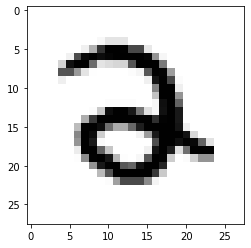

In [14]:
with torch.no_grad():#역전파과정을 위해 일반적으로 훈련시 모든 Tensor값의 grad를 마련해두는데, 테스트시에는 미분을 하지 않아 이 값이 필요없기에 비활성화하여 연산의 효율을 돕는다.
  #1. 테스트데이터를 이용하여 모델 정확도 산출하기
  X_test=mnist_test.test_data.view(-1, 28*28).float().to(device)#테스트데이터를 훈련시와 마찬가지로 모델 입력으로 사용하기 위해 784모양으로 바꿔준다.
  Y_test=mnist_test.test_labels.to(device)

  prediction=linear(X_test)#훈련된 Linear모델을 통과시켜 예측값을 얻는다.
  correct_prediction=torch.argmax(prediction, 1)==Y_test#prediction된 값중 가장 큰 확률을 가지는 값을 1로 바꾼 뒤(원-핫 벡터로 만든 뒤) 레이블데이터와 비교한다.
  accuracy=correct_prediction.float().mean()#모든 테스트데이터의 비교된 값들의 평균을 통해 정확도를 산출한다.
  print('Accuracy: ', accuracy.item())

  #2. 임의의 데이터로 모델 테스트하기
  r=random.randint(0, len(mnist_test)-1)
  X_single_data=mnist_test.test_data[r: r+1].view(-1, 28*28).float().to(device)
  Y_single_data=mnist_test.test_labels[r:r+1].to(device)

  print('Label: ', Y_single_data.item())
  single_prediction=linear(X_single_data)
  print('Prediction: ', torch.argmax(single_prediction, 1).item())

  plt.imshow(mnist_test.test_data[r:r+1].view(28,28), cmap='Greys', interpolation='nearest')
  plt.show()